In [27]:
# execute this cell before you start

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import datetime
import IPython
import IPython.display
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)
print(tf.keras.__version__)

2.9.1
2.9.0


## The Cork Historical Weather Dataset

The Dataset was downloaded from [The Irish Meteorological Service website](https://www.met.ie//climate/available-data/historical-data). The data corresponds readings taken at the Data Station No.3904, which is located at Cork Airport. The data is hourly and goes from \[01-Jan-1992 $\rightarrow$ 01-Feb-2022\].

A key was provided with the dataset download. It describes the columns as:
- **rain** | Precipitation Amount | mm
- **temp** | Air Temperature | °C
- **wetb** | Wet Bulb Air Temperature | °C
- **dewpt** | Dew Point Air Temperature | °C                 
- **vappr** |Vapour Pressure | hpa
- **rhum** | Relative Humidity | %
- **msl** | Mean Sea Level Pressure | hPa
- **wdsp** | Mean Hourly Wind Speed | kt
- **wddir** | Predominant Hourly wind Direction | kt
- **ww** | Synop Code Present Weather
- **w**| Synop Code Past Weather
- **sun** | Sunshine duration | hours
- **vis** | Visibility | m
- **clht** | Cloud Ceiling Height | 100s feet
- **clamt** | Cloud Amount | 
------------------------
Using this data I will train a reccurent model that will be able to predict the next 48 hours into the future given the previous 72 hours weather. I will train 2 different types, one will just predict the tempurature as with the tutorial, next I will predict the tempurature, 

## Read in the data

The data is read in and loaded in to Python from the downloaded CSV file. This is achieved using the package Pandas.


In [28]:
data = pd.read_csv('hly3904.csv')
print(data.shape)
data.dtypes

(263737, 21)


/home/patrick/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,8,9,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


date      object
ind        int64
rain     float64
ind.1      int64
temp     float64
ind.2      int64
wetb      object
dewpt    float64
vappr     object
rhum      object
msl      float64
ind.3      int64
wdsp       int64
ind.4      int64
wddir      int64
ww         int64
w          int64
sun      float64
vis       object
clht       int64
clamt      int64
dtype: object

Using the Python shape() method we can see that there are over 250,000 inidividual entries with 21 correspondig objects of varying data types. 

## Data Cleaning

As some of the data was read in as objects or strings rather than floats or ints, our first step is to change them to numeric values. Next we will assess if there are any blank values. If a cell is blank we will interpolate the value of that cell using a cubic spline. This will ensure that we are not missing data. This should give a good enough approximation considering the size f the dataset. 

At this stage, we will also reduce the size of the dataset as it is currently very large. For this project, we will drop the first 100,000 values from the dataset.



In [29]:
data = data.drop(index=np.arange(0,100000)) #drop the first 100000 hours
date_time = pd.to_datetime(data.pop('date')) #removes the date element of the database and converts the database to pandas datetime object
cols = ['wetb','vappr','rhum','vis'] #creates a list of the data that was read in as objects
for x in cols:
    data[x] = pd.to_numeric(data[x], errors = 'coerce')#data[col].astype(float)
    data[x] = data[x].interpolate(method = 'cubic')

The next is to remove the categorical data that we do not need.

We will drop the following columns:

- **ww** | Synop Code Present Weather
- **w**| Synop Code Past Weather


In [30]:
cols = ['ww','w','ind','ind.1','ind.2','ind.3','ind.4']
data = data.drop(cols,axis=1)


data.head()

,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
100000,0.0,17.0,15.0,13.4,15.4,80.0,1016.6,8,110,1.0,30000.0,250,6
100001,0.0,16.6,13.3,10.5,12.6,67.0,1016.4,9,120,1.0,30000.0,250,5
100002,0.0,15.7,12.4,9.4,11.8,66.0,1016.4,8,110,0.9,25000.0,250,5
100003,0.0,15.1,12.6,10.3,12.6,73.0,1016.4,7,110,1.0,16000.0,999,2
100004,0.0,13.4,11.7,10.2,12.4,81.0,1016.3,4,90,0.1,10000.0,999,1


## Feature Engineering

Before we build the model, we must first understand the data and be sure that appropriately formatted data is passed to the model.

### Wind

The last column of the data, **wd (deg)**—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

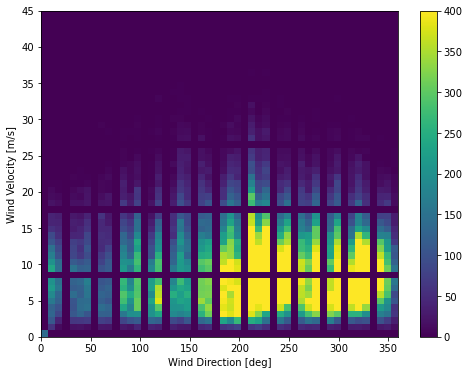

In [31]:
plt.hist2d(data['wddir'], data['wdsp'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')


But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector.

Like the [Tensorflow Time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series) we will be combining the windspeed and direction as they are not great predictors on their own. We will then normalise the data around 0. The model will not train well at all unless everything is on the same scale.

In [32]:
wv = data.pop('wdsp') #iscolate the windspeed values
# Convert to radians.
wd_rad = data.pop('wddir')*np.pi / 180 #iscolate the wind direction values (converting from degree to radians)
# Calculate the wind x and y components.
data['Wx'] = wv*np.cos(wd_rad)
data['Wy'] = wv*np.sin(wd_rad)


The distribution of wind vectors is much simpler for the model to correctly interpret:

(-40.40678269379406, 28.190778623577252, -45.0, 33.48346360241507)

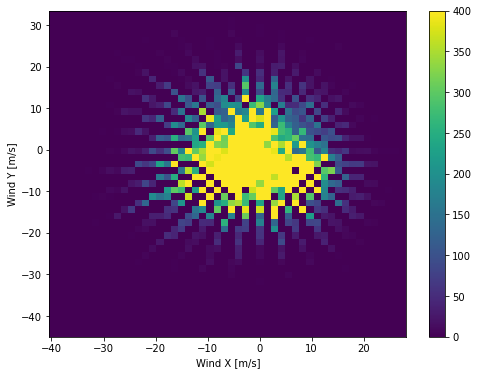

In [33]:
plt.hist2d(data['Wx'], data['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

### Time

Similarly, the Date Time column is very useful, but not in this string form. Start by converting it to seconds:

In [34]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [35]:
day = 24*60*60
year = (365.2425)*day

data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of day signal')

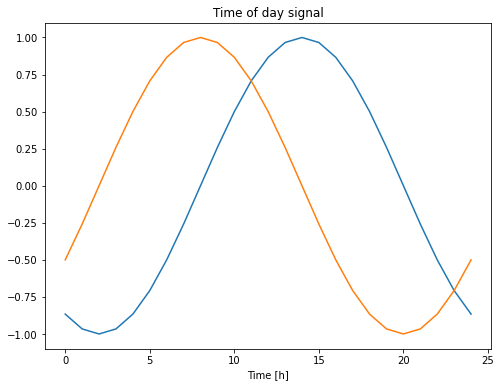

In [36]:
plt.plot(np.array(data['Day sin'])[:25])
plt.plot(np.array(data['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')


This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

## Normailising the data

In [37]:
data_mean = data.mean()
data_std = data.std()
data_df = (data - data_mean)/data_std
data_df

,rain,temp,wetb,dewpt,vappr,rhum,msl,sun,vis,clht,clamt,Wx,Wy,Day sin,Day cos,Year sin,Year cos
100000,-0.252332,1.566339,1.399407,1.287693,1.401488,-0.549924,0.173622,2.507500,0.190459,-0.062406,0.142595,-0.136828,1.470619,-1.224683,-0.707138,0.803572,-1.174750
100001,-0.252332,1.477574,1.014381,0.639944,0.531194,-1.644103,0.157068,2.507500,0.190459,-0.062406,-0.277872,-0.371346,1.509755,-1.365963,-0.366056,0.802722,-1.175306
100002,-0.252332,1.277855,0.810544,0.394246,0.282538,-1.728270,0.157068,2.205397,-0.122018,-0.062406,-0.277872,-0.136828,1.470619,-1.414150,-0.000031,0.801873,-1.175862
100003,-0.252332,1.144709,0.855841,0.595272,0.531194,-1.139097,0.157068,2.507500,-0.684478,1.749517,-1.539275,-0.091353,1.337707,-1.365963,0.365995,0.801023,-1.176418
100004,-0.252332,0.767461,0.652004,0.572936,0.469030,-0.465757,0.148791,-0.211430,-1.059452,1.749517,-1.959743,0.226969,0.973091,-1.224683,0.707077,0.800172,-1.176972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263732,-0.252332,-0.586192,-0.661612,-0.811906,-0.836411,-0.549924,1.547593,-0.513533,0.190459,-0.604289,0.563063,-0.136828,-0.655976,-1.224683,0.707077,0.747021,1.210872
263733,-0.252332,-0.475237,-0.593666,-0.811906,-0.836411,-0.718259,1.497932,-0.513533,0.190459,-0.606708,0.563063,-0.091353,-0.523064,-0.999940,0.999971,0.747896,1.210355
263734,-0.252332,-0.430855,-0.548369,-0.722561,-0.805329,-0.718259,1.448270,-0.513533,0.190459,-0.618804,0.563063,-0.091353,-0.523064,-0.707049,1.224716,0.748770,1.209838
263735,-0.252332,-0.430855,-0.525720,-0.655553,-0.743165,-0.634092,1.365501,-0.513533,0.190459,1.749517,-1.118807,-0.096264,-1.542786,-0.365970,1.365996,0.749643,1.209319


If we look at the data again now, we have removed 7 usless predictors and all of the data has been normalised. 

We will now assess the correlation coefficient to see if there are more feature can be remove d so that the model can be better trained. The correlation coefficient is a statistical measure of the strength of a linear relationship between two variables. Its values can range from -1 to 1. We will be looking to see how correlated different columns are with each other. 

If a column is >90% correlated we will remove it as it is just repeating information that is being provided by another.

In [38]:
data_df.corr().abs()

,rain,temp,wetb,dewpt,vappr,rhum,msl,sun,vis,clht,clamt,Wx,Wy,Day sin,Day cos,Year sin,Year cos
rain,1.000000,0.012426,0.059798,0.113893,0.112400,0.219188,0.240627,0.110781,0.277820,0.151231,0.196934,0.212032,0.115598,0.002419,0.002081,0.017707,0.038028
temp,0.012426,1.000000,0.921341,0.873485,0.863315,0.206887,0.085049,0.250102,0.134770,0.213397,0.216465,0.188503,0.003977,0.174078,0.223854,0.347680,0.675880
wetb,0.059798,0.921341,1.000000,0.915144,0.905670,0.029547,0.035189,0.111026,0.031404,0.262490,0.282718,0.260251,0.021498,0.103526,0.139682,0.367789,0.609595
dewpt,0.113893,0.873485,0.915144,1.000000,0.987644,0.292160,0.014601,0.037384,0.208273,0.329252,0.367126,0.355546,0.048411,0.032392,0.054746,0.403108,0.556135
vappr,0.112400,0.863315,0.905670,0.987644,1.000000,0.286679,0.013459,0.035050,0.211920,0.313406,0.351365,0.340502,0.059283,0.032851,0.058328,0.408561,0.558425
rhum,0.219188,0.206887,0.029547,0.292160,0.286679,1.000000,0.203620,0.561294,0.702392,0.246345,0.319569,0.350416,0.115292,0.281154,0.331772,0.117837,0.215953
msl,0.240627,0.085049,0.035189,0.014601,0.013459,0.203620,1.000000,0.083517,0.182919,0.116833,0.131005,0.231334,0.147561,0.001517,0.007473,0.035323,0.072622
sun,0.110781,0.250102,0.111026,0.037384,0.035050,0.561294,0.083517,1.000000,0.444098,0.301506,0.364267,0.163587,0.068862,0.052524,0.475503,0.048826,0.188861
vis,0.277820,0.134770,0.031404,0.208273,0.211920,0.702392,0.182919,0.444098,1.000000,0.296032,0.379552,0.334622,0.178480,0.181418,0.234450,0.008163,0.236414
clht,0.151231,0.213397,0.262490,0.329252,0.313406,0.246345,0.116833,0.301506,0.296032,1.000000,0.918072,0.266537,0.057173,0.007626,0.108862,0.020595,0.019114


We now have the information that we require however it is time consuming to assess the values. We can improve the anaylsis process with a clear visual, in this case a heat map. We will assign the value into a seaborn heatmap.

<AxesSubplot:>

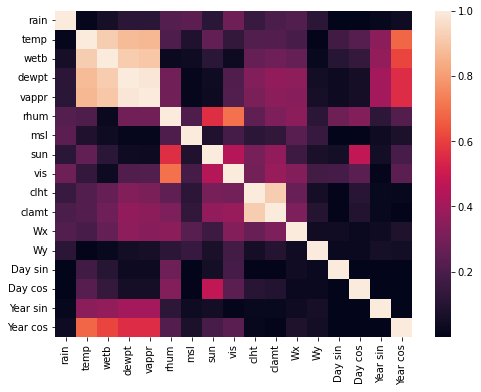

In [39]:
sns.heatmap(data_df.corr().abs())

The Seaborn heatmap presents our data in a clear distinct manner. We can clear distinguish that there is a cluster of highly correlated data in the top left containing the temp,wetb,dewpt and vappr features.

When we look at the features closer, we can see that the all report on the temperature with justifies the high correlation.vappr being the only exception as it is showing Vapour Pressure. In conclusion, We will decide to remove wetb and dewpt and preform this correlation coefficiet check again.

<AxesSubplot:>

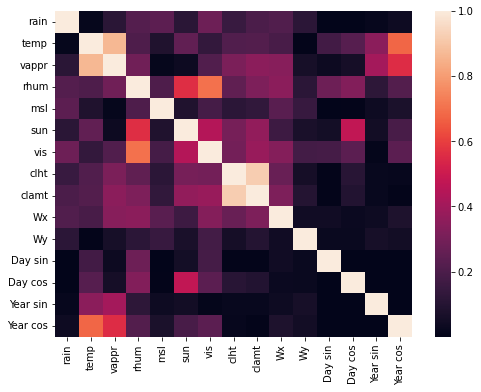

In [40]:
data_df = data_df.drop('wetb', axis=1)
data_df = data_df.drop('dewpt',axis=1)
sns.heatmap(data_df.corr().abs())

On reflection, the features now all look to be contriuting somethig different which looks  like a suitable dataset to train on.

We will now look at the evolution of a few features over time using the plotting code from the tutorial.

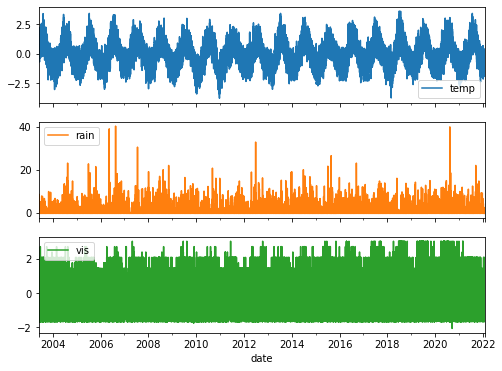

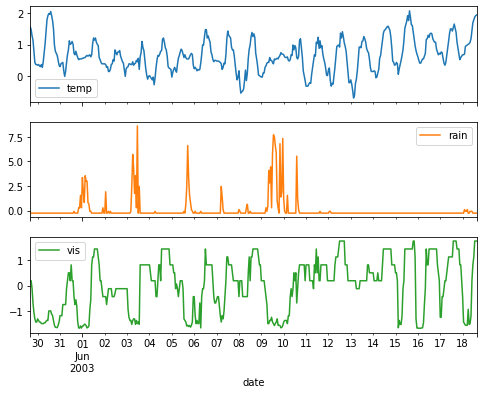

In [41]:
plot_cols = ['temp', 'rain', 'vis']
plot_features = data_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data_df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Split the data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

   - It ensures that chopping the data into windows of consecutive samples is still possible.
   - It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.


In [42]:
n = data_df.shape[0]

train_df = data_df[0:int(n*0.7)]
val_df = data_df[int(n*0.7):int(n*0.9)]
test_df = data_df[int(n*0.9):]

## Data windowing

### 1. Indexes and offsets

Start by creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to tf.data.Datasets of windows later.

In [43]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
         f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

### 2. Split

Given a list of consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

The example w2 you define earlier will be split like this:

In [44]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [45]:
#custom plotting function
def plot_results(model, window,features, subplot = False):
    pred_num = len(features)
    plt.figure(figsize = (20,3))
    label_width = OUT_STEPS
    shift = OUT_STEPS
    input_width = 72
    batch_num = 1
    total_window_size = input_width + shift

    input_slice = slice(0, input_width)
    input_indices = np.arange(total_window_size)[input_slice]


    label_start = total_window_size - label_width
    labels_slice = slice(label_start, None)
    label_indices = np.arange(total_window_size)[labels_slice]
    
    for i, l in window.test.take(1):
        inputs = i
        labels = l
        break
        
    column_indices = {name: i for i, name in enumerate(train_df.columns)}
    predictions = model(inputs)
    print(predictions.shape)
    cols = ['red','orange','blue','green','yellow']

    for i in range(pred_num):
        if subplot:
            plt.figure(figsize = (20,10))
            plt.subplot(pred_num,1,i+1)
            plt.title(features[i])
            
        plot_col_index = column_indices[features[i]]
        plt.plot(input_indices, inputs[batch_num, :, plot_col_index],label='Input', marker='.', zorder=-10,color = cols[i])
        plt.scatter(label_indices, labels[batch_num,:,i], marker ='o',label = 'True' ,color = cols[i])
        #plt.scatter(label_indices, labels[batch_num,:,i], marker ='o',label = 'Prediction' ,color = cols[i])
        plt.scatter(label_indices, predictions[batch_num,:,i], marker ='x', color = 'green', label = 'prediction')
        plt.legend()
        plt.grid()

### 4. Create tf.data.Datasets

Finally, this make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:

In [46]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The WindowGenerator object holds training, validation, and test data.

Add properties for accessing them as tf.data.Datasets using the make_dataset method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [47]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Making the Windowed Data

In [48]:
OUT_STEPS = 48
cork_window_temp = WindowGenerator(input_width=72,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                            train_df=train_df, val_df=val_df ,test_df=test_df, label_columns = ['temp'])

# Defining the Model
The model below is to predict tempuratue. It is the same as the model that was used in the tutorial section. this time it has a single output layer where the output dimensions are `(None, 48,1)`, To match the windowed data, As I have only asked it to used tempurature in the labels. This should hopfully improve the accuracy. You will see this output shape in the model summary.

In [49]:
#num_features = data_df.columns.size
num_features = 15
temp_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    #tf.keras.layers.Dense(8, activation = 'selu'),
    tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    tf.keras.layers.Dense(1)
])

448/448 [==============================] - 28s 56ms/step - loss: 0.2285 - mean_absolute_error: 0.3644 - val_loss: 0.1964 - val_mean_absolute_error: 0.3403
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                6144      
                                                                 
 dense_4 (Dense)             (None, 720)               23760     
                                                                 
 reshape_2 (Reshape)         (None, 48, 15)            0         
                                                                 
 dense_5 (Dense)             (None, 48, 1)             16        
                                                                 
Total params: 29,920
Trainable params: 29,920
Non-trainable params: 0
_________________________________________________________________
(256, 48, 1)
(256, 48, 1)
(

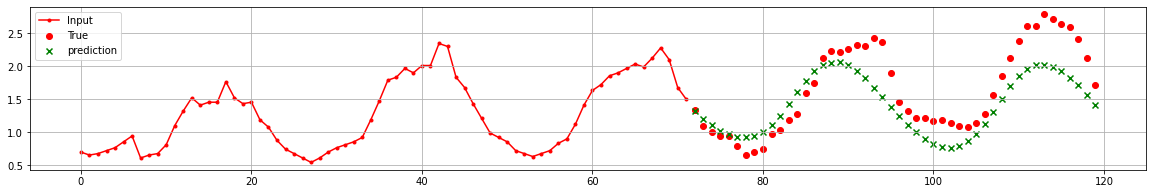

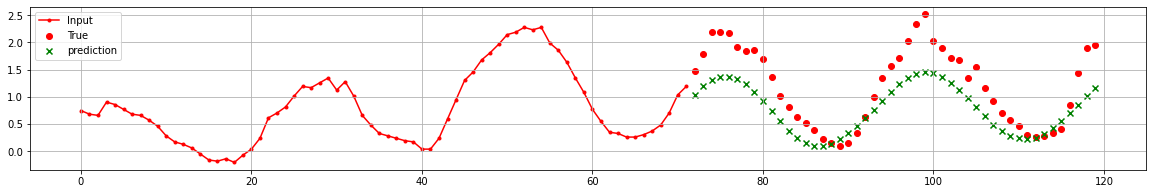

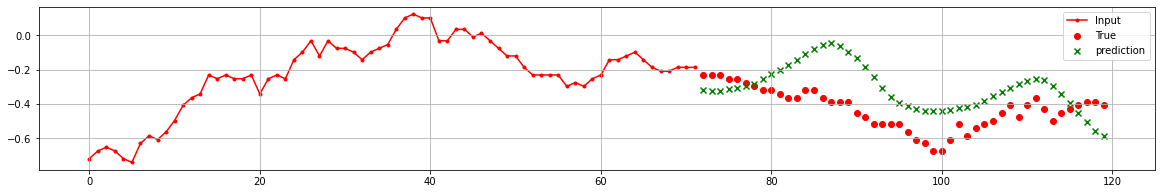

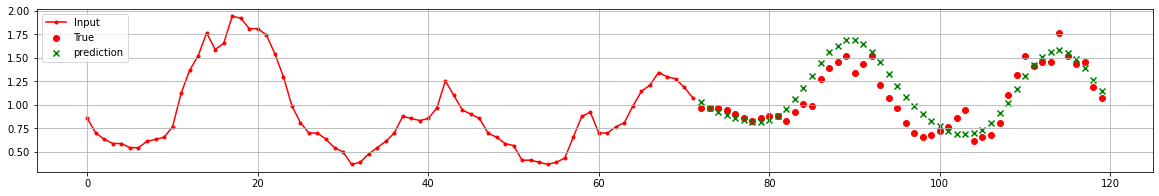

In [50]:
def compile_and_fit(model, window,MAX_EPOCHS = 3 ,patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    model.summary()
    return history

compile_and_fit(temp_lstm_model,cork_window_temp,MAX_EPOCHS=1)

for i in range(4):
    plot_results(model=temp_lstm_model,window = cork_window_temp, features=['temp'], subplot=False)

In [51]:
accuracy = temp_lstm_model.evaluate(cork_window_temp.test, verbose=1)

64/64 [==============================] - 2s 27ms/step - loss: 0.1901 - mean_absolute_error: 0.3390


From our results we cans see that the mean absolute error is relativly high at 0.3655. 

From my understanding, I understand this to be due to the amount fo data that is considered. I've made this assessment based on he fact that some of the results are totally wrong yet some of the results are very close to matching the actual value. 

Looking at the results, It is my opinion that temperature is the easiest feature to predict based due to its cylical nature. Temp will drop at night and rise during the day.

The next model tests the LSTMs ability to predict the tempurature, rainfall and the wind vectors as these are far less tied to the day/night cycle, so I am not expecting as good results.

Epoch 1/3
448/448 [==============================] - 27s 56ms/step - loss: 0.6638 - mean_absolute_error: 0.5178 - val_loss: 0.6155 - val_mean_absolute_error: 0.5091
Epoch 2/3
448/448 [==============================] - 25s 55ms/step - loss: 0.6062 - mean_absolute_error: 0.4846 - val_loss: 0.6056 - val_mean_absolute_error: 0.5002
Epoch 3/3
448/448 [==============================] - 25s 55ms/step - loss: 0.5945 - mean_absolute_error: 0.4777 - val_loss: 0.6030 - val_mean_absolute_error: 0.4995
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                6144      
                                                                 
 dense_6 (Dense)             (None, 720)               23760     
                                                                 
 reshape_3 (Reshape)         (None, 48, 15)            0         
                     

<Figure size 1440x216 with 0 Axes>

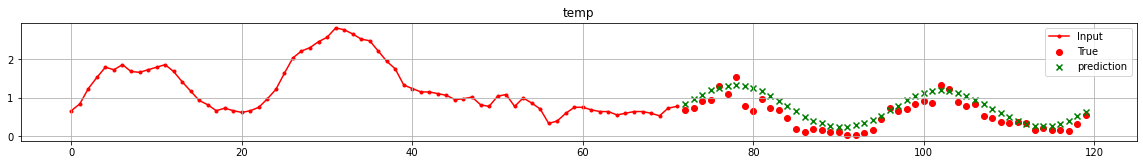

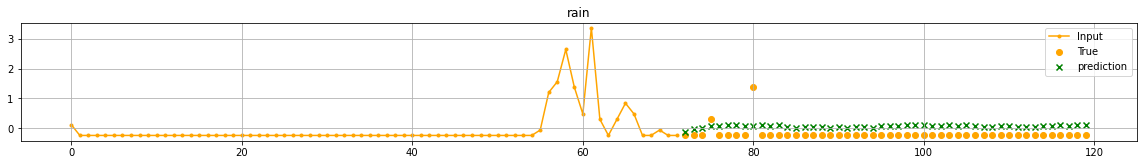

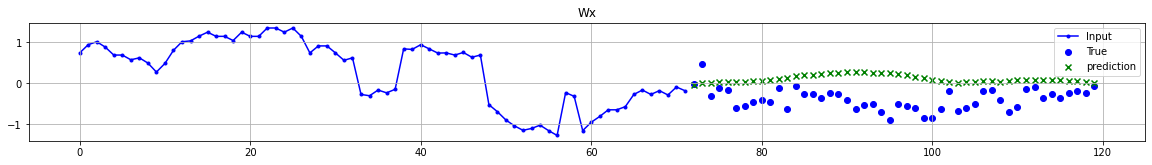

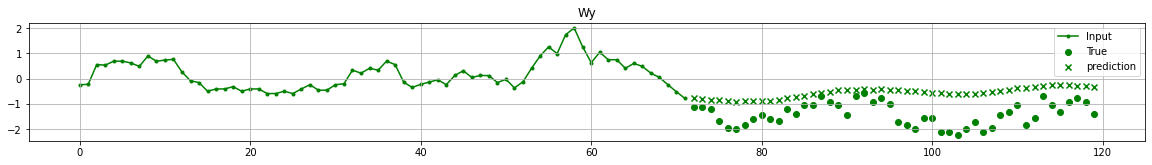

In [52]:
OUT_STEPS = 48
cork_window_multi = WindowGenerator(input_width=72,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, train_df=train_df, val_df=val_df ,test_df=test_df, label_columns = ['temp','rain','Wx','Wy'])

num_features = 15
multi_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    #tf.keras.layers.Dense(8, activation = 'selu'),
    tf.keras.layers.Reshape([OUT_STEPS, num_features]),
    tf.keras.layers.Dense(4)
])
compile_and_fit(multi_lstm_model,cork_window_multi)
plot_results(model=multi_lstm_model,window = cork_window_multi, features=['temp','rain','Wx','Wy'], subplot=True)

Once again looking at our results, the output graphs above, the LSTM appears to have trained very well. It is by no means perfect and definatly stuggles the most with predicting the rain the most as it has alot of no rainfall values.

To improve on these results I would need to run ore epochs on a deeper network of LSTMs (which requires more computing power). With these improvements, there is potential to develop an accurate model.


## In Conclusion

As a reusult of going through the tutorial and making the modifications necesscary, I have made a number fo conclusions about training LSTMs.

1. For time series data, normalising the data is absolutly critical. If the dataset is not normalised convergence will not happen. If we use unormalised data the output is almost always a straight line, unable to make any significant predications.

2. Making the LSTM layers have more units or adding more LSTM layers is a good way to increase the accuracy and increase convergence. However this comes at the cost of training time. Like CNNs it appers as though one can only really leverage them for all they are worth in terms of depth with more powerful hardware.

3. From what I could see there appears to be a trade off between giving the model too much historical data vs a small amount, that is why I landed on giving my Cork model 3 days to predict ahead the next 48

4. There did not seem to be much over fitting, I am sure with more complex models this is bound to happen. 

4. Overall performance was good, espellilly on the tempurature matric. I belive as it simply ocsillates at different frequecies, I think that is why in the correlation heatmap it was correlated to the cos wave.